# Gefcom2014 Forecasting

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.models as models
import deep4cast.custom_metrics as metrics
import deep4cast.utils as utils
import deep4cast.cv as cv

%matplotlib inline

Using TensorFlow backend.
/Users/toby/anaconda3/envs/deep_forecast/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Parameters

In [2]:
horizon = 24*30
lag = horizon
filters = 64
num_layers = 2

# Data preparation

In [5]:
# Loading the dataset and dropping unncecessary columns
df = pd.read_pickle('../data/processed/GEFCom2014-e.pkl')
df = df[-40000:]

data = df.drop(['month', 'day', 'hour'], axis=1)
data = data.dropna()

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['load', 'temperature']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create lagged real features to include information about past year's behavior
lagged = data[real_values].shift(365*24-horizon)
lagged = lagged.rename(columns={column:column + '_yearly_lagged' for column in lagged.columns})
data = pd.concat([data, lagged], axis=1)
data = data.dropna()
data = data.reset_index(drop=True)

# Let's shift the holidays back by the horizon length for better forecasting on holidays
data['holiday'] = data['holiday'].shift(-horizon)

# Training & testing boundary
test_ind = data.index.where(data['time'] == dt.datetime(2014,11,1,0,0,0)).dropna().astype('int').values[0]

# Create a numpy array drop date columns
data_arr = data.drop(['time'], axis=1)
data_arr = np.expand_dims(data_arr.values, 0)

# Now we need to sequentialize the training and testing dataset
X_train, y_train = utils.sequentialize(data_arr[:,:test_ind,:], lag, horizon, targets=[0])
X_test, y_test = utils.sequentialize(data_arr[:,test_ind-lag:,:], lag, horizon, targets=[0])

# Rescale the datasets so that the neural networks can be fitted properly and stably
scaler = cv.VectorScaler(targets=[0, 1, -2, -1])
scaler.fit_x(X_train)
scaler.fit_y(y_train)
X_train = scaler.transform_x(X_train)
X_test = scaler.transform_x(X_test)
y_train = scaler.transform_y(y_train)

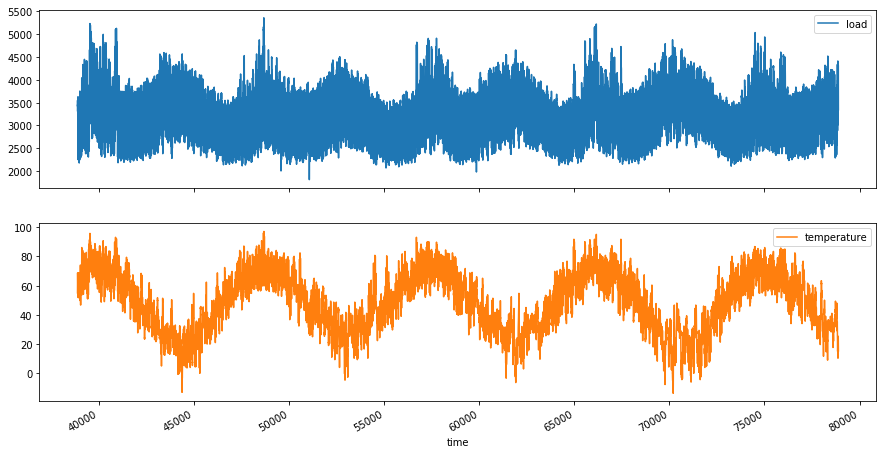

In [6]:
# Let plot the data to help our imagination
df[['load', 'temperature']].plot(subplots=True, figsize=(15, 8))
plt.xlabel('time')
plt.show()

# Modeling

In [7]:
model = models.WaveNet(filters=filters, num_layers=num_layers)

forecaster = Forecaster(
    model,
    lag=lag,  # This is the number of time steps used to predict the future for each data point
    horizon=horizon,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=1
)

forecaster.fit(X_train, y_train, verbose=1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Epoch 1/1
29056/29056 [==============================] - 149s 5ms/step - loss: -0.8940


# Evaluation

In [8]:
# Testing set evaluation
y_test_eval = y_test[::horizon]
y_test_eval = np.reshape(y_test_eval, y_test_eval.shape[0]*y_test_eval.shape[1])
y_test_eval = np.atleast_2d(y_test_eval).T

# Build prediction time series
samples = forecaster.predict(X_test[::horizon,:,:])
samples = scaler.inverse_transform_y(samples)
test_samples = []
for i in range(samples.shape[1]):
    test_samples.append(samples[:,i,:,:])
test_samples = np.concatenate(test_samples, axis=1)
test_mean = np.mean(test_samples, axis=0)
test_lq = np.percentile(test_samples, q=5, axis=0)
test_uq = np.percentile(test_samples, q=95, axis=0)

# Test set days
test_dates = data.time[test_ind:test_mean.shape[0]+test_ind]

SMAPE: 4.75%
Pinball Score: 56.71
Coverage: 


Text(0,0.5,'model percentile')

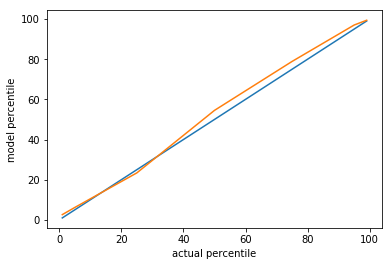

In [9]:
test_smape = metrics.smape(test_samples, y_test_eval)
test_cov, test_perc = metrics.coverage(test_samples, y_test_eval)
test_pinball = metrics.pinball_loss(test_samples, y_test_eval)

print('SMAPE: {}%'.format(test_smape))
print('Pinball Score: {}'.format(test_pinball))
print('Coverage: ')

plt.plot(test_perc, test_perc)
plt.plot(test_perc, test_cov)
plt.xlabel('actual percentile')
plt.ylabel('model percentile')

Text(0,0.5,'Load')

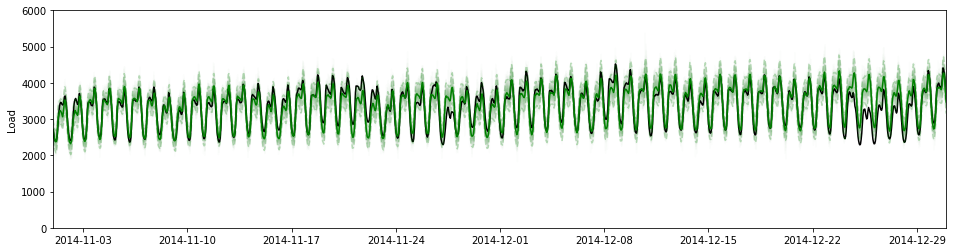

In [11]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(16, 4))

plt.plot(test_dates, test_samples[::20,:,0].T, 'g-', alpha=0.01)
plt.plot(test_dates, y_test_eval, 'k-')
plt.plot(test_dates, test_mean, 'g-')
plt.plot(test_dates, test_uq, 'g--', alpha=0.25)
plt.plot(test_dates, test_lq, 'g--', alpha=0.25)


plt.ylim([0, 6000])
plt.xlim([test_dates.values[0], test_dates.values[-1]])

plt.ylabel('Load')